In [38]:
from __future__ import annotations

import operator
from pathlib import Path
from typing import TypedDict, List, Optional, Literal, Annotated

from pydantic import BaseModel, Field

from langgraph.graph import StateGraph, START, END
from langgraph.types import Send

from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_community.tools.tavily_search import TavilySearchResults


In [39]:
load_dotenv()

True

In [26]:
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

In [ ]:
# -----------------------------
# 1) Schemas
# -----------------------------
class Task(BaseModel):
    id: int
    title: str

    goal: str = Field(
        ...,
        description="One sentence describing what the reader should be able to do/understand after this section.",
    )
    bullets: List[str] = Field(
        ...,
        min_length=3,
        max_length=5,
        description="3–6 concrete, non-overlapping subpoints to cover in this section.",
    )
    target_words: int = Field(
        ...,
        description="Target word count for this section (120–450).",
    )
    section_type: Literal[
        "intro", "core", "examples", "checklist", "common_mistakes", "conclusion"
    ] = Field(
        ...,
        description="Use 'common_mistakes' exactly once in the plan.",
    )

class Plan(BaseModel):
    blog_title:str
    audience:str= Field(...,description="Who this blog is for")
    tone: str= Field(...,description="What tone the blog should have eg:practical, crisp, technical, etc")
    tasks:List[Task]= Field(description="A list of tasks to complete the blog")

class State(TypedDict):
    topic: str
    plan: Plan
    section_results: Annotated[List[str], operator.add]  # reducer appends each worker's output
    final_blog: str
    

In [30]:
def orchestrator(state:State) -> dict:
    """ Orchestrator function will generate the plan to write the blog """
    planner = llm.with_structured_output(Plan)
    plan = planner.invoke(
        [
            SystemMessage(
                content=(
                    "You are a senior technical writer and developer advocate. Your job is to produce a "
                    "highly actionable outline for a technical blog post.\n\n"
                    "Hard requirements:\n"
                    "- Create 5–7 sections (tasks) that fit a technical blog.\n"
                    "- Each section must include:\n"
                    "  1) goal (1 sentence: what the reader can do/understand after the section)\n"
                    "  2) 3–5 bullets that are concrete, specific, and non-overlapping\n"
                    "  3) target word count (120–450)\n"
                    "- Include EXACTLY ONE section with section_type='common_mistakes'.\n\n"
                    "Make it technical (not generic):\n"
                    "- Assume the reader is a developer; use correct terminology.\n"
                    "- Prefer design/engineering structure: problem → intuition → approach → implementation → "
                    "trade-offs → testing/observability → conclusion.\n"
                    "- Bullets must be actionable and testable (e.g., 'Show a minimal code snippet for X', "
                    "'Explain why Y fails under Z condition', 'Add a checklist for production readiness').\n"
                    "- Explicitly include at least ONE of the following somewhere in the plan (as bullets):\n"
                    "  * a minimal working example (MWE) or code sketch\n"
                    "  * edge cases / failure modes\n"
                    "  * performance/cost considerations\n"
                    "  * security/privacy considerations (if relevant)\n"
                    "  * debugging tips / observability (logs, metrics, traces)\n"
                    "- Avoid vague bullets like 'Explain X' or 'Discuss Y'. Every bullet should state what "
                    "to build/compare/measure/verify.\n\n"
                    "Ordering guidance:\n"
                    "- Start with a crisp intro and problem framing.\n"
                    "- Build core concepts before advanced details.\n"
                    "- Include one section for common mistakes and how to avoid them.\n"
                    "- End with a practical summary/checklist and next steps.\n\n"
                    "Output must strictly match the Plan schema."
                )
            ),
            HumanMessage(content=f"topic: {state['topic']}"),
        ]
    )
    return {"plan":plan}
    

In [31]:
def fanout(state:State):
    """ this function will call worker nodes required number of times as per the generated plan"""
    return [
        Send(
            "worker", 
            {'topic': state['topic'], 'task': task, 'plan': state['plan']}
        )
        for task in state['plan'].tasks
    ]
    

In [32]:
def worker(payload:dict) -> dict:
    """ this function will write the blog section """

    # Receive the payload from the fanout node (task/plan may be dict if serialized)
    topic = payload['topic']
    task = payload['task']
    plan = payload['plan']
    plan_title = plan.blog_title if hasattr(plan, 'blog_title') else plan['blog_title']
    task_title = task.title if hasattr(task, 'title') else task['title']
    task_goal = task.goal if hasattr(task, 'goal') else task['goal']
    task_bullets = task.bullets if hasattr(task, 'bullets') else task['bullets']
    
    # Generate the blog section
    blog_section_markdown = llm.invoke(
        [
            SystemMessage(
                content=(
                    "You are a senior technical writer and developer advocate. Write ONE section of a technical blog post in Markdown.\n\n"
                    "Hard constraints:\n"
                    "- Follow the provided Goal and cover ALL Bullets in order (do not skip or merge bullets).\n"
                    "- Stay close to the Target words (±15%).\n"
                    "- Output ONLY the section content in Markdown (no blog title H1, no extra commentary).\n\n"
                    "Technical quality bar:\n"
                    "- Be precise and implementation-oriented (developers should be able to apply it).\n"
                    "- Prefer concrete details over abstractions: APIs, data structures, protocols, and exact terms.\n"
                    "- When relevant, include at least one of:\n"
                    "  * a small code snippet (minimal, correct, and idiomatic)\n"
                    "  * a tiny example input/output\n"
                    "  * a checklist of steps\n"
                    "  * a diagram described in text (e.g., 'Flow: A -> B -> C')\n"
                    "- Explain trade-offs briefly (performance, cost, complexity, reliability).\n"
                    "- Call out edge cases / failure modes and what to do about them.\n"
                    "- If you mention a best practice, add the 'why' in one sentence.\n\n"
                    "Markdown style:\n"
                    "- Start with a '## <Section Title>' heading.\n"
                    "- Use short paragraphs, bullet lists where helpful, and code fences for code.\n"
                    "- Avoid fluff. Avoid marketing language.\n"
                    "- If you include code, keep it focused on the bullet being addressed.\n"
                )
            ),
            HumanMessage(
                content=(
                    f"Blog Title: {plan_title}\n"
                    f"topic: {topic}\n"
                    f"section: {task_title}\n"
                    f"goal: {task_goal}\n"
                    f"bullets: {task_bullets}\n"
                    f"Return only the section content in Markdown format"
                )
            )
        ]
    ).content.strip()
    
    # Must return "section_results" (plural) as a list for operator.add reducer to merge
    return {"section_results": [blog_section_markdown]}
    

In [33]:
from pathlib import Path

def reducer(state:State) -> dict:
    """ this function will reduce the results of the worker nodes into a single final blog """
    plan = state['plan']
    title = plan.blog_title if hasattr(plan, 'blog_title') else plan['blog_title']
    section_results = state.get('section_results') or []
    body = "\n\n".join(section_results).strip()
    final_markdown = f"# {title}\n\n{body}"

    # Save the final blog to a file
    filename=title.lower().replace(" ","_")+".md"
    output_path = Path(filename)
    output_path.write_text(final_markdown, encoding="utf-8")

    return {"final_blog":final_markdown}

In [34]:
graph = StateGraph(State)

graph.add_node("orchestrator",orchestrator)
graph.add_node("worker",worker)
graph.add_node("reducer",reducer)

graph.add_edge(START, "orchestrator")
graph.add_conditional_edges("orchestrator",fanout,["worker"])
graph.add_edge("worker", "reducer")
graph.add_edge("reducer", END)

app = graph.compile()



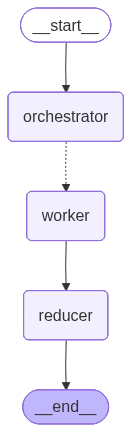

In [35]:
app

In [36]:
input_state = {"topic":"Self-Attention in Transformer Models"}

output_state = app.invoke(input_state)
print(output_state)



{'topic': 'Self-Attention in Transformer Models', 'plan': Plan(blog_title='Understanding Self-Attention in Transformer Models', audience='Developers and Machine Learning Engineers', tone='technical', tasks=[Task(id=1, title='Introduction to Self-Attention', goal='Understand the concept of self-attention and its role in transformer models.', bullets=['Define self-attention and its significance in natural language processing (NLP).', 'Explain how self-attention differs from traditional attention mechanisms.', 'Introduce the basic architecture of a transformer model, highlighting the self-attention component.'], target_words=300, section_type='intro'), Task(id=2, title='The Problem with Sequence Models', goal='Identify the limitations of traditional sequence models that self-attention addresses.', bullets=['Discuss the vanishing gradient problem in RNNs and LSTMs.', 'Explain how fixed-length context windows limit information capture in sequence models.', 'Highlight the inefficiency of pro

In [37]:
for task in output_state['plan'].tasks:
    print(f"Task Title: {task.title}")
    print(f"Task Goal: {task.goal}")
    print(f"Task Bullets: {task.bullets}")
    print("\n")

Task Title: Introduction to Self-Attention
Task Goal: Understand the concept of self-attention and its role in transformer models.
Task Bullets: ['Define self-attention and its significance in natural language processing (NLP).', 'Explain how self-attention differs from traditional attention mechanisms.', 'Introduce the basic architecture of a transformer model, highlighting the self-attention component.']


Task Title: The Problem with Sequence Models
Task Goal: Identify the limitations of traditional sequence models that self-attention addresses.
Task Bullets: ['Discuss the vanishing gradient problem in RNNs and LSTMs.', 'Explain how fixed-length context windows limit information capture in sequence models.', 'Highlight the inefficiency of processing sequences in a linear manner.']


Task Title: Intuition Behind Self-Attention
Task Goal: Grasp the underlying intuition of how self-attention works.
Task Bullets: ["Illustrate the concept of 'query', 'key', and 'value' vectors in self-at